In [2]:
!pip install detecto

In [1]:
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


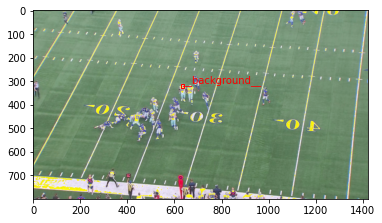

In [ ]:
from torchvision import transforms
from detecto import core, utils, visualize


# Specify a list of transformations for our dataset to apply on our images
transform_img = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(800),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    utils.normalize_transform(),
])

dataset = core.Dataset('/content/train.csv', '/content/drive/MyDrive/nfl_impact_detection/kaggle_train_frame/', transform=transform_img)

# dataset[i] returns a tuple containing our transformed image and
# and a dictionary containing label and box data
image, target = dataset[2030]

# Show our image along with the box. Note: it may
# be colored oddly due to being normalized by the 
# dataset and then reverse-normalized for plotting
visualize.show_labeled_image(image, target['boxes'], target['labels'])

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0/784 [00:00<?, ?it/s]

Epoch 1 of 7
Begin iterating over training dataset


  0%|          | 0/891 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/784 [00:00<?, ?it/s]

Loss: 0.10774213744170115
Epoch 2 of 7
Begin iterating over training dataset


  0%|          | 1/891 [00:00<01:51,  7.96it/s]

Begin iterating over validation dataset


  0%|          | 0/784 [00:00<?, ?it/s]

Loss: 0.09098542980482859
Epoch 3 of 7
Begin iterating over training dataset


  0%|          | 1/891 [00:00<01:52,  7.93it/s]

Begin iterating over validation dataset


  0%|          | 0/784 [00:00<?, ?it/s]

Loss: 0.0881217485709235
Epoch 4 of 7
Begin iterating over training dataset


  0%|          | 1/891 [00:00<01:53,  7.81it/s]

Begin iterating over validation dataset


  0%|          | 0/784 [00:00<?, ?it/s]

Loss: 0.08585778618103111
Epoch 5 of 7
Begin iterating over training dataset


  0%|          | 1/891 [00:00<01:55,  7.72it/s]

Begin iterating over validation dataset


  0%|          | 0/784 [00:00<?, ?it/s]

Loss: 0.08582710430226972
Epoch 6 of 7
Begin iterating over training dataset


  0%|          | 1/891 [00:00<01:52,  7.90it/s]

Begin iterating over validation dataset


  0%|          | 0/784 [00:00<?, ?it/s]

Loss: 0.08708943978412438
Epoch 7 of 7
Begin iterating over training dataset


  0%|          | 1/891 [00:00<01:53,  7.81it/s]

Begin iterating over validation dataset


100%|██████████| 891/891 [01:12<00:00, 12.21it/s]


Loss: 0.08662982962495233


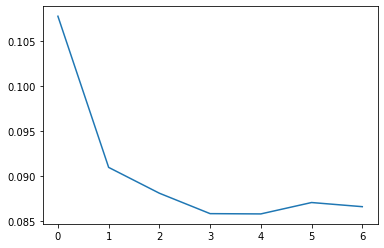

In [ ]:
import matplotlib.pyplot as plt

# Create our validation dataset
val_dataset = core.Dataset('val.csv', '/content/drive/MyDrive/nfl_impact_detection/kaggle_train_frame/')

# Create the loader for our training dataset
loader = core.DataLoader(dataset, batch_size=4, shuffle=True)

# Create our model, passing in all unique classes we're predicting
# Note: make sure these match exactly with the labels in the XML/CSV files!
model = core.Model(['Helmet'], device='cuda')

# Train the model! This step can take a while, so make sure you
# the GPU is turned on in Edit -> Notebook settings
losses = model.fit(loader, val_dataset, epochs=7, verbose=True)

# Plot the accuracy over time
plt.plot(losses)
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/nfl_impact_detection/model_weights.pth')

In [1]:
from detecto import core, utils, visualize
from detecto.core import Model

model = Model.load('/content/drive/MyDrive/nfl_impact_detection/model_weights.pth', ['Helmet'])

In [2]:
import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch

from detecto.utils import reverse_normalize, normalize_transform, _is_iterable
from torchvision import transforms

def detect_video(model, input_file, output_file, fps=30, score_filter=0.6):
    """Takes in a video and produces an output video with object detection
    run on it (i.e. displays boxes around detected objects in real-time).
    Output videos should have the .avi file extension. Note: some apps,
    such as macOS's QuickTime Player, have difficulty viewing these
    output videos. It's recommended that you download and use
    `VLC <https://www.videolan.org/vlc/index.html>`_ if this occurs.
    :param model: The trained model with which to run object detection.
    :type model: detecto.core.Model
    :param input_file: The path to the input video.
    :type input_file: str
    :param output_file: The name of the output file. Should have a .avi
        file extension.
    :type output_file: str
    :param fps: (Optional) Frames per second of the output video.
        Defaults to 30.
    :type fps: int
    :param score_filter: (Optional) Minimum score required to show a
        prediction. Defaults to 0.6.
    :type score_filter: float
    **Example**::
        >>> from detecto.core import Model
        >>> from detecto.visualize import detect_video
        >>> model = Model.load('model_weights.pth', ['tick', 'gate'])
        >>> detect_video(model, 'input_vid.mp4', 'output_vid.avi', score_filter=0.7)
    """

    # Read in the video
    video = cv2.VideoCapture(input_file)

    # Video frame dimensions
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Scale down frames when passing into model for faster speeds
    scaled_size = 800
    scale_down_factor = min(frame_height, frame_width) / scaled_size

    # The VideoWriter with which we'll write our video with the boxes and labels
    # Parameters: filename, fourcc, fps, frame_size
    out = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*'DIVX'), fps, (frame_width, frame_height))

    # Transform to apply on individual frames of the video
    transform_frame = transforms.Compose([  # TODO Issue #16
        transforms.ToPILImage(),
        transforms.Resize(scaled_size),
        transforms.ToTensor(),
        normalize_transform(),
    ])

    # Loop through every frame of the video
    while True:
        ret, frame = video.read()
        # Stop the loop when we're done with the video
        if not ret:
            break

        # The transformed frame is what we'll feed into our model
        transformed_frame = transform_frame(frame)
        # transformed_frame = frame  # TODO: Issue #16
        predictions = model.predict(transformed_frame)

        # Add the top prediction of each class to the frame
        for label, box, score in zip(*predictions):
            if score < score_filter:
                continue

            # Since the predictions are for scaled down frames,
            # we need to increase the box dimensions
            box *= scale_down_factor  # TODO Issue #16

            # Create the box around each object detected
            # Parameters: frame, (start_x, start_y), (end_x, end_y), (r, g, b), thickness
            cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 3)

            # Write the label and score for the boxes
            # Parameters: frame, text, (start_x, start_y), font, font scale, (r, g, b), thickness
            cv2.putText(frame, '{}: {}'.format(label, round(score.item(), 2)), (box[0], box[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

        # Write this frame to our video file
        out.write(frame)

        # If the 'q' key is pressed, break from the loop
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break

    # When finished, release the video capture and writer objects
    video.release()
    out.release()

    # Close all the frames
    cv2.destroyAllWindows()

In [3]:
import pandas as pd

def detect_video_df(model, input_file, 
                 gameKey, 
                 playID,
                 view,
                 videoname, 
                 fps=30, score_filter=0.6):

    # Read in the video
    dictionary = {'gameKey': [],
                  'playID': [],
                  'view': [],
                  'video':[],
                  'frame': [],
                  'left': [],
                  'width': [],
                  'top': [],
                  'height': []}
    video = cv2.VideoCapture(input_file)

    # Video frame dimensions
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Scale down frames when passing into model for faster speeds
    scaled_size = 800
    scale_down_factor = min(frame_height, frame_width) / scaled_size

    # The VideoWriter with which we'll write our video with the boxes and labels
    # Parameters: filename, fourcc, fps, frame_size
    

    # Transform to apply on individual frames of the video
    transform_frame = transforms.Compose([  # TODO Issue #16
        transforms.ToPILImage(),
        transforms.Resize(scaled_size),
        transforms.ToTensor(),
        normalize_transform(),
    ])

    # Loop through every frame of the video
    i = 1
    while True:
        ret, frame = video.read()
        # Stop the loop when we're done with the video
        if not ret:
            break

        # The transformed frame is what we'll feed into our model
        transformed_frame = transform_frame(frame)
        # transformed_frame = frame  # TODO: Issue #16
        predictions = model.predict(transformed_frame)

        # Add the top prediction of each class to the frame
        for label, box, score in zip(*predictions):
            if score < score_filter:
                continue

            # Since the predictions are for scaled down frames,
            # we need to increase the box dimensions
            box *= scale_down_factor  # TODO Issue #16

            # Create the box around each object detected
            # Parameters: frame, (start_x, start_y), (end_x, end_y), (r, g, b), thickness
            # cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 3)
            dictionary['gameKey'].append(gameKey)
            dictionary['playID'].append(gameKey)
            dictionary['view'].append(view)
            dictionary['video'].append(videoname)
            dictionary['frame'].append(i)
            dictionary['left'].append(int(box[0].item()))
            dictionary['width'].append(int(abs((box[0]-box[2]).item())))
            dictionary['top'].append(int(box[1].item()))
            dictionary['height'].append(int(abs((box[1]-box[3]).item())))
            # Write the label and score for the boxes
            # Parameters: frame, text, (start_x, start_y), font, font scale, (r, g, b), thickness

        i += 1


        # If the 'q' key is pressed, break from the loop
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break

    # When finished, release the video capture and writer objects
    video.release()
    output_df = pd.DataFrame.from_dict(dictionary)
    # Close all the frames
    cv2.destroyAllWindows()

    return output_df

In [4]:
df1 = detect_video_df(model, 
                  '/content/drive/MyDrive/nfl_impact_detection/test/57906_000718_Endzone.mp4',
                  '57906', 
                  '718',
                  'Endzone',
                  '57906_000718_Endzone.mp4',  
                  score_filter=0.6)

df2 = detect_video_df(model, 
                  '/content/drive/MyDrive/nfl_impact_detection/test/57906_000718_Sideline.mp4',
                  '57906', 
                  '718',
                  'Sideline',
                  '57906_000718_Sideline.mp4',  
                  score_filter=0.4)

df3 = detect_video_df(model, 
                  '/content/drive/MyDrive/nfl_impact_detection/test/57995_000109_Endzone.mp4',
                  '57995', 
                  '109',
                  'Endzone',
                  '57995_000109_Endzone.mp4',  
                  score_filter=0.6)

df4 = detect_video_df(model, 
                  '/content/drive/MyDrive/nfl_impact_detection/test/57995_000109_Sideline.mp4',
                  '57995', 
                  '109',
                  'Sideline',
                  '57995_000109_Sideline.mp4',  
                  score_filter=0.6)

df5 = detect_video_df(model, 
                  '/content/drive/MyDrive/nfl_impact_detection/test/58102_002798_Endzone.mp4',
                  '58102', 
                  '2798',
                  'Endzone',
                  '58102_002798_Endzone.mp4',  
                  score_filter=0.6)

df6 = detect_video_df(model, 
                  '/content/drive/MyDrive/nfl_impact_detection/test/58102_002798_Sideline.mp4',
                  '58102', 
                  '2798',
                  'Sideline',
                  '58102_002798_Sideline.mp4',  
                  score_filter=0.5)

In [7]:
test_df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)

In [9]:
test_df.to_csv('test_data.csv', index=False)

In [3]:
#from detecto.visualize import detect_video

detect_video(model, '/content/drive/MyDrive/nfl_impact_detection/test/57906_000718_Endzone.mp4', 'output1.avi', score_filter=0.6)

In [11]:
#from detecto.visualize import detect_video
detect_video(model, '/content/drive/MyDrive/nfl_impact_detection/test/57906_000718_Sideline.mp4', 'output2.avi', score_filter=0.35)

In [10]:
detect_video(model, '/content/drive/MyDrive/nfl_impact_detection/test/57995_000109_Endzone.mp4', 'output3.avi', score_filter=0.6)

In [6]:
detect_video(model, '/content/drive/MyDrive/nfl_impact_detection/test/57995_000109_Sideline.mp4', 'output4.avi', score_filter=0.6)

In [7]:
detect_video(model, '/content/drive/MyDrive/nfl_impact_detection/test/58102_002798_Endzone.mp4', 'output5.avi', score_filter=0.6)

In [12]:
detect_video(model, '/content/drive/MyDrive/nfl_impact_detection/test/58102_002798_Sideline.mp4', 'output6.avi', score_filter=0.5)

In [ ]:
from sklearn.model_selection import KFold
from copy import deepcopy
from torchvision import transforms
from detecto import core, utils, visualize
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
# Specify a list of transformations for our dataset to apply on our images
transform_img = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(800),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    utils.normalize_transform(),
])

kf = KFold(n_splits=5)
for train_index, test_index in kf.split(tr_vl_data):
    tr_data = deepcopy(tr_vl_data.iloc[train_index])
    vl_data = deepcopy(tr_vl_data.iloc[test_index])

    frames_train = pd.unique(tr_data['filename'])
    fr_train = dict(zip(frames_train, range(len(frames_train))))

    frames_val = pd.unique(vl_data['filename'])
    fr_val = dict(zip(frames_val, range(len(frames_val))))

    tr_data['image_id'] = tr_data['filename'].apply(lambda x: fr_train[x])
    vl_data['image_id'] = vl_data['filename'].apply(lambda x: fr_val[x])

    tr_data.to_csv('train.csv', index=False)
    vl_data.to_csv('val.csv', index=False) 

    random.seed(6)
    np.random.seed(6)
    torch.manual_seed(6)
    torch.cuda.manual_seed(6)
    torch.backends.cudnn.deterministic = True

    dataset = core.Dataset('/content/train.csv', '/content/drive/MyDrive/nfl_impact_detection/kaggle_train_frame/', transform=transform_img)

    # Create our validation dataset
    val_dataset = core.Dataset('val.csv', '/content/drive/MyDrive/nfl_impact_detection/train_frame/')

    # Create the loader for our training dataset
    loader = core.DataLoader(dataset, batch_size=2, shuffle=True)

    # Create our model, passing in all unique classes we're predicting
    # Note: make sure these match exactly with the labels in the XML/CSV files!
    model = core.Model(['Helmet'])

    # Train the model! This step can take a while, so make sure you
    # the GPU is turned on in Edit -> Notebook settings
    losses = model.fit(loader, val_dataset, epochs=6, verbose=True)

    # Plot the accuracy over time
    plt.plot(losses)
    plt.show()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0/1574 [00:00<?, ?it/s]

Epoch 1 of 6
Begin iterating over training dataset


  0%|          | 0/893 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/1574 [00:00<?, ?it/s]

Loss: 0.09380287554872213
Epoch 2 of 6
Begin iterating over training dataset


 25%|██▌       | 398/1574 [01:55<05:39,  3.47it/s]

KeyboardInterrupt: ignored